In [1]:
import pandas as pd
import numpy as np
import sklearn
from matplotlib import pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras import optimizers
from sklearn import model_selection
from keras import regularizers
from keras.callbacks import EarlyStopping
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report

In [2]:
def padronizar_normal(matriz_X):
    for i in range(np.shape(matriz_X)[1]):
        matriz_X[:,i] = (matriz_X[:,i] - np.mean(matriz_X[:,i]))/np.std(matriz_X[:,i]) # X menos media/desvio padrao

    return matriz_X

def normalizar(X):
    min_values = X.min(axis=0)
    max_values = X.max(axis=0)
    X = (X - min_values) / (max_values - min_values)
    return X


In [5]:
def k_fold(num_splits, numero_neuronios,dimensao_imput, list_funcoes_ativacao, X_train, Y_train, RANDOM_STATE, BATCH_SIZE, es = False, regularizador = False):
  kfold = StratifiedKFold(n_splits=num_splits, shuffle=True, random_state=RANDOM_STATE)
  accuracies_train = []
  accuracies_val = []
  history_list = []
  tamanho_history_history_loss_list = []
  i = 0
  for index_treino, index_val in kfold.split(X_train, Y_train):
      i += 1
      X_train_fold, X_val_fold = X_train[index_treino], X_train[index_val]
      Y_train_fold, Y_val_fold = Y_train[index_treino], Y_train[index_val]

      # Criando a rede neural
      model = Sequential()
      # Adicionando neurônios em uma camada oculta
      if regularizador == False:
        model.add(Dense(numero_neuronios, input_dim=dimensao_imput, kernel_initializer='normal', activation=list_funcoes_ativacao[0])) #quantidade de neuronios na camada escondida, nº de features (selu, relu, gelu)
      else:
        model.add(Dense(numero_neuronios, input_dim=dimensao_imput, kernel_initializer='normal', kernel_regularizer=regularizers.l2(0.01),activation=list_funcoes_ativacao[0]))
      model.add(Dense(1, kernel_initializer='normal', activation=list_funcoes_ativacao[1])) #camada de saída

      # adicionando a taxa de aprendizado
      learning_rate = 0.001  

      # Criando um otimizador Adam com a taxa de aprendizado desejada
      otimizador = optimizers.Adam(learning_rate=learning_rate)

      if es == False:
        # Compilando o modelo
        model.compile(loss = 'binary_crossentropy', optimizer = otimizador, metrics = ['accuracy'])
        #Treinando o modelo
        history = model.fit(X_train_fold, Y_train_fold, validation_data=(X_val_fold, Y_val_fold), epochs=250, batch_size=BATCH_SIZE, verbose=0)
        history_list.append(history)
        tamanho_history_history_loss_list.append(len(history.history['loss']))

      else:
        es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)
        # Compilando o modelo
        model.compile(loss = 'binary_crossentropy', optimizer = otimizador, metrics = ['accuracy'])
        #Treinando o modelo
        history = model.fit(X_train_fold, Y_train_fold, validation_data=(X_val_fold, Y_val_fold), epochs=250, batch_size=BATCH_SIZE, verbose=0, callbacks = [es])
        history_list.append(history)
        tamanho_history_history_loss_list.append(len(history.history['loss']))


      # Avalia o modelo
      _, accuracy_train = model.evaluate(X_train_fold, Y_train_fold, batch_size=BATCH_SIZE, verbose=0)
      _, accuracy_val = model.evaluate(X_val_fold, Y_val_fold, batch_size=BATCH_SIZE, verbose=0)
      accuracies_train.append(accuracy_train)
      accuracies_val.append(accuracy_val)

      # Exibe o historico de treinamento para um fold especifico
      plt.plot(history.history['loss'])
      plt.plot(history.history['val_loss'])
      plt.title(f'Metrica de erro - Fold {i}')
      plt.ylabel('Erro')
      plt.xlabel('Epoca')
      plt.legend(['Treinamento', 'Validacao'])
      plt.show()

      print(f'--> Acuracia (treino): {accuracy_train:.4f}')
      print(f'--> Acuracia (validacao): {accuracy_val:.4f}')
      print(f"--> Ein - Eval = {accuracy_train - accuracy_val:.4f}") 
      print(f"--> val_loss - train_loss = {(history.history['val_loss'][-1] - history.history['loss'][-1]):.4f}\n")
        

  # Calcula a acuracia media
  acuracia_media_treino = np.mean(accuracies_train)
  acuracia_media_validacao = np.mean(accuracies_val)

  # Historico com valores medios dos folds
  history_train_loss_avg_list = []
  history_val_losso_avg_list = []

  for epoca in range(max(tamanho_history_history_loss_list)):
      list_valores_loss_train = []
      list_valores_loss_val = []
      for j in range(len(history_list)):
          if epoca < len(history_list[j].history['loss']): # verifica se a epoca existe no historico do fold j por causa do early stopping
              list_valores_loss_train.append(history_list[j].history['loss'][epoca])
              list_valores_loss_val.append(history_list[j].history['val_loss'][epoca])
      history_train_loss_avg_list.append(np.mean(list_valores_loss_train)) # Calcula a média dos valores de loss para cada epoca (media da epoca 1, media da epoca 2...)
      history_val_losso_avg_list.append(np.mean(list_valores_loss_val))                           

  loss_medio_treino = np.mean(history_train_loss_avg_list)
  loss_medio_val = np.mean(history_val_losso_avg_list)

  plt.plot(history_train_loss_avg_list)
  plt.plot(history_val_losso_avg_list)
  plt.title('Metrica de erro - Media dos Folds')
  plt.ylabel('Erro')
  plt.xlabel('Epoca')
  plt.legend(['Treinamento', 'Validacao'])
  plt.show()

  print(f'--> Acuracia media (treino): {acuracia_media_treino:.4f}')
  print(f'--> Acuracia media (validacao): {acuracia_media_validacao:.4f}')
  print(f"--> acc_in - acc_val = {acuracia_media_treino - acuracia_media_validacao:.4f}")
  print(f"--> loss medio do treino = {loss_medio_treino:.4f}")
  print(f"--> loss medio da validacao = {loss_medio_val:.4f}")  
  print(f"--> val_loss - train_loss = {(loss_medio_val - loss_medio_treino):.4f}\n")

In [6]:
"""

Para ter o dataset original acesse: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud

dataframe_original = pd.read_csv('creditcard.csv')
print("Dimensões do dataframe: ",dataframe_original.shape)
print("Quantidades de cada classe:", dataframe_original['Class'].value_counts())
# Reduzindo a quantidade de amostras para 10000 da classe 0 e todas da classe 1
dataframe_original = dataframe_original.sample(frac=1) # embaralhando as amostras
fraude = dataframe_original.loc[dataframe_original['Class'] == 1]
nao_fraude = dataframe_original.loc[dataframe_original['Class'] == 0][:10000]
dataframe_reduzido = pd.concat([fraude, nao_fraude])
dataframe_reduzido.to_csv('creditcard_reduced.csv', index=False)"""

'dataframe_original = pd.read_csv(\'creditcard.csv\')\nprint("Dimensões do dataframe: ",dataframe_original.shape)\nprint("Quantidades de cada classe:", dataframe_original[\'Class\'].value_counts())\n# Reduzindo a quantidade de amostras para 10000 da classe 0 e todas da classe 1\ndataframe_original = dataframe_original.sample(frac=1) # embaralhando as amostras\nfraude = dataframe_original.loc[dataframe_original[\'Class\'] == 1]\nnao_fraude = dataframe_original.loc[dataframe_original[\'Class\'] == 0][:10000]\ndataframe_reduzido = pd.concat([fraude, nao_fraude])\ndataframe_reduzido.to_csv(\'creditcard_reduced.csv\', index=False)'

In [12]:
data = pd.read_csv('creditcard_reduced.csv')
data

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,472.0,-3.043541,-3.157307,1.088463,2.288644,1.359805,-1.064823,0.325574,-0.067794,-0.270953,...,0.661696,0.435477,1.375966,-0.293803,0.279798,-0.145362,-0.252773,0.035764,529.00,1
1,62080.0,-1.599457,2.607720,-2.987193,3.064156,-2.497914,-0.541103,-2.277786,1.268166,-1.997331,...,0.662933,0.184087,-0.089452,-0.506000,-0.062259,-0.052714,0.322854,0.135268,180.00,1
2,149096.0,1.184891,3.152084,-6.134780,5.531252,1.733867,-1.816861,-0.916696,0.265568,-3.158014,...,0.124236,-0.823865,-0.079887,0.028828,0.389711,0.060171,0.485187,0.326552,0.00,1
3,93860.0,-10.632375,7.251936,-17.681072,8.204144,-10.166591,-4.510344,-12.981606,6.783589,-4.659330,...,2.715357,0.695603,-1.138122,0.459442,0.386337,0.522438,-1.416604,-0.488307,188.52,1
4,102622.0,-2.877176,4.569649,-9.553069,4.441079,-3.653961,-1.877981,-3.514353,1.547608,-2.503304,...,1.272896,1.300268,-0.003950,-0.360848,-0.597526,-0.390901,0.592197,-0.241010,346.94,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10487,29135.0,1.148470,-0.226385,-1.378984,-0.501250,2.115918,3.156576,-0.191150,0.725852,-0.240172,...,-0.497682,-1.855851,0.146490,0.960612,0.220649,-0.123232,-0.058349,0.027293,94.31,0
10488,161456.0,0.098372,0.881126,-0.412761,-0.501913,0.817211,-0.925919,0.864430,-0.038913,0.142891,...,-0.346648,-0.932954,0.134695,0.594512,-0.465915,0.113468,0.211053,0.083482,6.45,0
10489,20259.0,-0.230903,0.188957,1.950648,-1.682032,-0.491241,0.442542,-0.611728,-0.566704,2.466857,...,0.615393,-0.317370,-0.344081,-0.355076,1.492861,-0.662246,0.117670,0.129243,11.85,0
10490,32140.0,-0.818437,0.592785,0.468012,-0.279240,1.401790,-1.316362,0.647986,-0.015513,-0.784337,...,0.056923,-0.071114,-0.134238,-0.112990,-0.167753,0.148682,0.057840,0.164770,0.76,0


In [13]:
data = data.drop(['Time'], axis=1)
print(data['Class'].value_counts())
# Eu possuo 100 valores de classe 0 e 492 valores de classe 1. Deixando os valores iguals, 492 em cada classe
data = data.sample(frac=1)
fraude = data.loc[data['Class'] == 1]
nao_fraude = data.loc[data['Class'] == 0][:492]
normal_distributed_data = pd.concat([fraude, nao_fraude])
print(normal_distributed_data['Class'].value_counts())


Class
0    10000
1      492
Name: count, dtype: int64
Class
1    492
0    492
Name: count, dtype: int64


In [9]:
normal_distributed_data

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
221,-11.397727,7.763953,-18.572307,6.711855,-10.174216,-4.395918,-15.893788,2.083013,-4.988837,-15.346099,...,0.339007,1.342923,0.239217,0.534644,-0.174965,-0.500240,-1.722060,-0.574339,11.40,1
361,-0.067672,4.251181,-6.540388,7.283657,0.513541,-2.635066,-1.865911,0.780272,-3.868248,-4.851487,...,0.415437,-0.469938,0.007128,-0.388147,-0.493398,0.466468,0.566370,0.262990,0.77,1
198,0.539276,1.554890,-2.066180,3.241617,0.184736,0.028330,-1.515521,0.537035,-1.999846,-2.133176,...,0.371773,0.111955,-0.305225,-1.053835,0.771175,0.240878,0.418435,0.232170,19.02,1
300,-1.271244,2.462675,-2.851395,2.324480,-1.372245,-0.948196,-3.065234,1.166927,-2.268771,-4.881143,...,0.652941,0.081931,-0.221348,-0.523582,0.224228,0.756335,0.632800,0.250187,0.01,1
272,0.467992,1.100118,-5.607145,2.204714,-0.578539,-0.174200,-3.454201,1.102823,-1.065016,-5.416037,...,0.983481,0.899876,-0.285103,-1.929717,0.319869,0.170636,0.851798,0.372098,120.54,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7232,-0.319622,-3.214049,-0.142083,-0.032391,-1.946958,0.037541,0.307953,-0.107679,-1.113464,0.385388,...,-0.013864,-1.476372,-0.427964,0.248637,-0.543575,0.657124,-0.184527,0.151084,832.46,0
9290,-2.427922,2.762737,-2.581637,-1.439683,0.047359,-1.328645,0.395476,1.123521,0.099539,0.886119,...,0.229579,0.745007,0.000689,0.767232,0.020967,0.068799,0.634151,0.447402,7.70,0
4447,0.105154,0.854792,-0.178971,-0.875940,1.055902,-0.267056,0.962992,-0.080242,-0.050258,-0.427035,...,-0.311486,-0.742645,0.012570,0.031559,-0.360000,0.149537,0.242643,0.097590,4.49,0
1360,-0.999690,0.681567,-2.753857,-0.374143,1.728585,-1.147355,0.960126,0.222585,-0.495079,0.156055,...,0.446861,1.870864,0.598747,0.285610,-0.878531,-0.170582,0.071505,-0.096012,5.00,0


In [14]:
X = np.array(normal_distributed_data.drop('Class', axis=1))
Y = np.array(normal_distributed_data['Class'])
RANDOM_STATE = 2
BATCH_SIZE = 32

# Normalizando os dados
X = padronizar_normal(X) # Nesse caso, utilizaremos a padronização dos dados, pois a escala dos dados é importante para o treinamento da rede neural

# Separando em dados de treino, teste e validação
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, test_size=0.2, random_state=RANDOM_STATE)
X_train, X_val, Y_train, Y_val = model_selection.train_test_split(X_train, Y_train, test_size=0.2, random_state=RANDOM_STATE)

print('X_train:', X_train.shape)
print('Y_train:', Y_train.shape)
print('X_val:', X_val.shape)
print('Y_val:', Y_val.shape)

X_train: (629, 29)
Y_train: (629,)
X_val: (158, 29)
Y_val: (158,)


In [11]:
# Encontrando o número de neurônios na camada escondida
num_neuronios = (X_train.shape[0] - 10)/(10*(X_train.shape[1] + 2))
num_neuronios

1.9967741935483871

# Kfold para checar se existe overfitting

c:\Users\Bergson\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


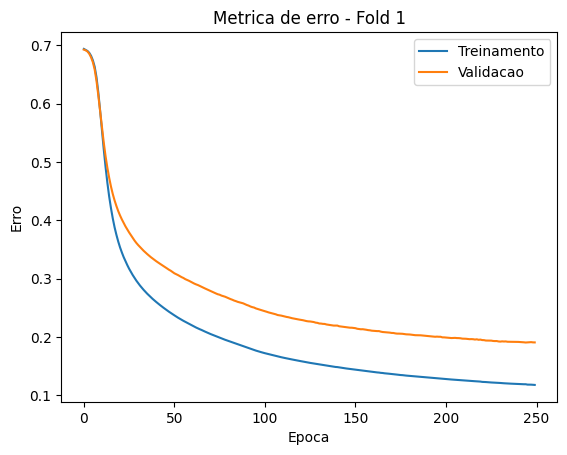

--> Acuracia (treino): 0.9622
--> Acuracia (validacao): 0.9127
--> Ein - Eval = 0.0495
--> val_loss - train_loss = 0.0729



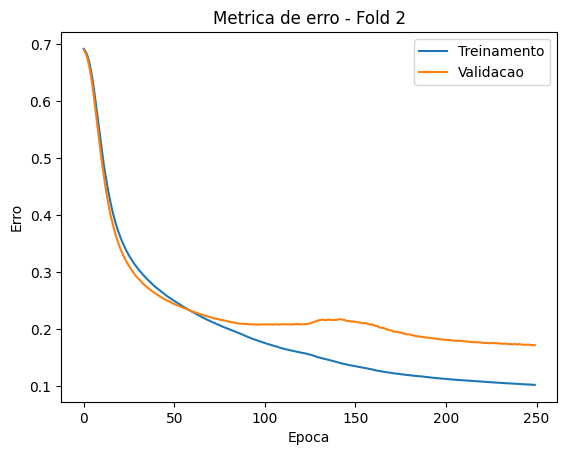

--> Acuracia (treino): 0.9642
--> Acuracia (validacao): 0.9365
--> Ein - Eval = 0.0277
--> val_loss - train_loss = 0.0697



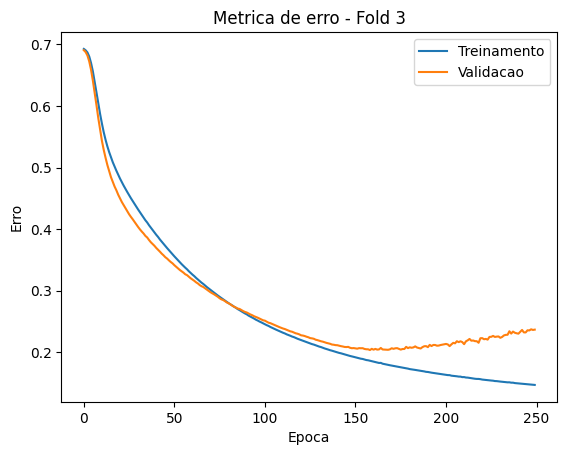

--> Acuracia (treino): 0.9523
--> Acuracia (validacao): 0.9365
--> Ein - Eval = 0.0158
--> val_loss - train_loss = 0.0898



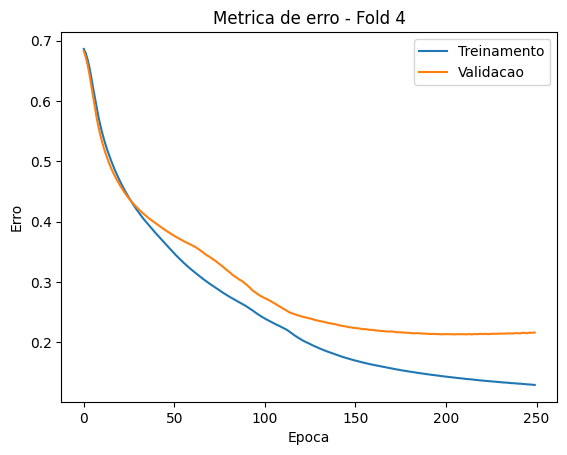

--> Acuracia (treino): 0.9682
--> Acuracia (validacao): 0.9127
--> Ein - Eval = 0.0555
--> val_loss - train_loss = 0.0869



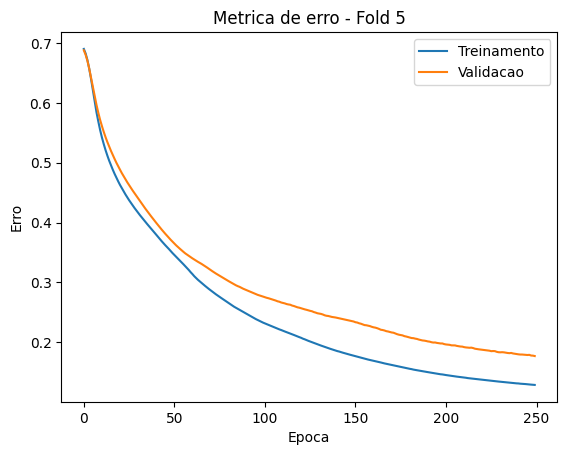

--> Acuracia (treino): 0.9603
--> Acuracia (validacao): 0.9280
--> Ein - Eval = 0.0323
--> val_loss - train_loss = 0.0483



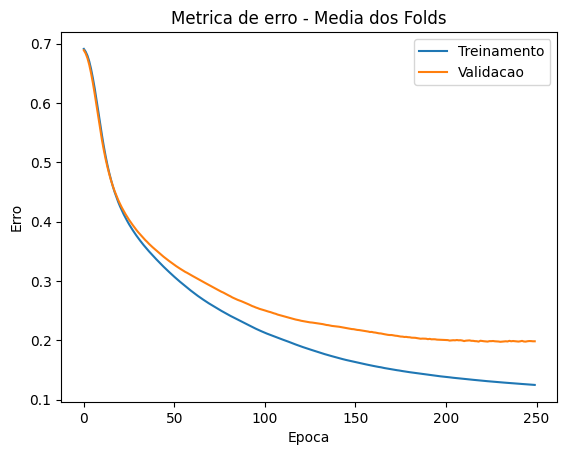

--> Acuracia media (treino): 0.9614
--> Acuracia media (validacao): 0.9253
--> acc_in - acc_val = 0.0362
--> loss medio do treino = 0.2325
--> loss medio da validacao = 0.2741
--> val_loss - train_loss = 0.0416



In [12]:
# Parâmetros: num_splits, numero_neuronios,dimensao_imput, list_funcoes_ativacao, X_train, Y_train, RANDOM_STATE, BATCH_SIZE, es = False, regularizador = False
k_fold(5, 2, X_train.shape[1], ['selu', 'sigmoid'], X_train, Y_train, RANDOM_STATE, BATCH_SIZE)

# Kfold para eliminar o overfitting

c:\Users\Bergson\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


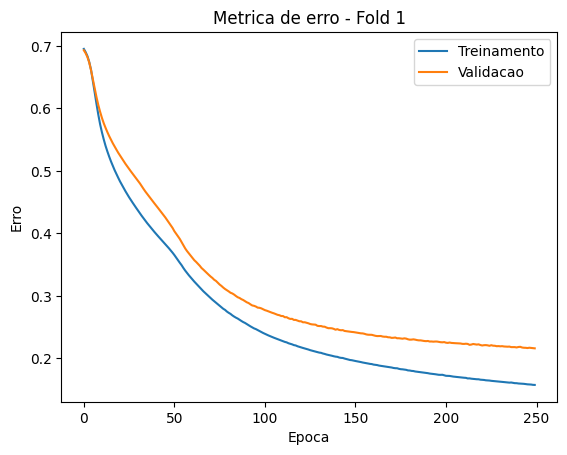

--> Acuracia (treino): 0.9622
--> Acuracia (validacao): 0.9286
--> Ein - Eval = 0.0337
--> val_loss - train_loss = 0.0586



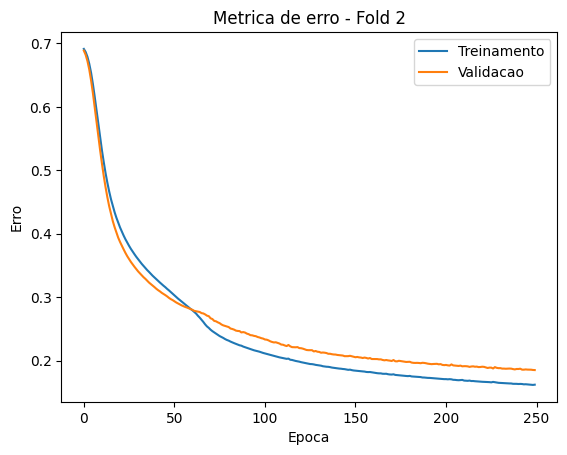

--> Acuracia (treino): 0.9563
--> Acuracia (validacao): 0.9524
--> Ein - Eval = 0.0039
--> val_loss - train_loss = 0.0230



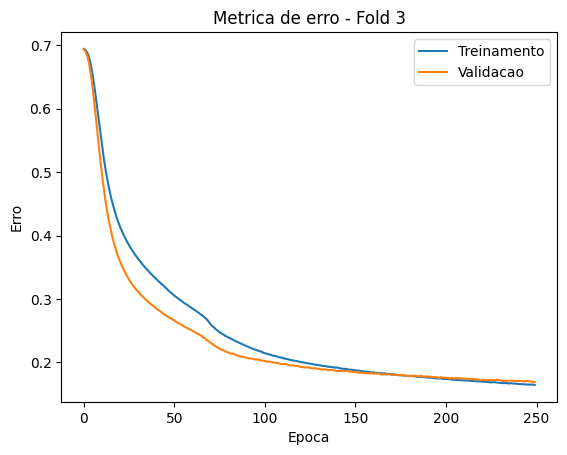

--> Acuracia (treino): 0.9503
--> Acuracia (validacao): 0.9603
--> Ein - Eval = -0.0100
--> val_loss - train_loss = 0.0044



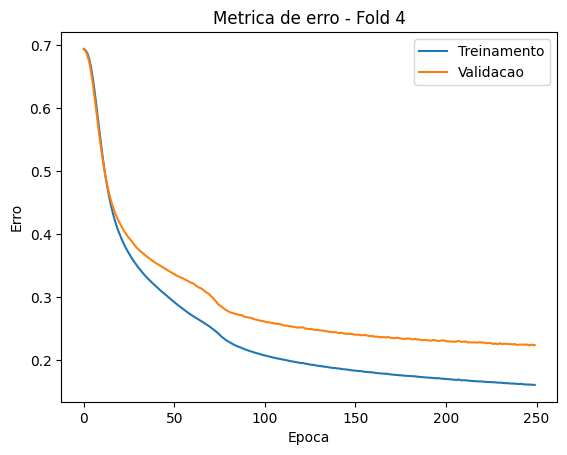

--> Acuracia (treino): 0.9523
--> Acuracia (validacao): 0.9206
--> Ein - Eval = 0.0317
--> val_loss - train_loss = 0.0631



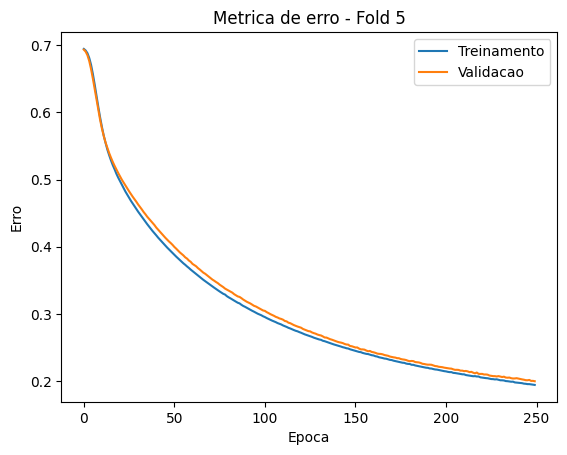

--> Acuracia (treino): 0.9524
--> Acuracia (validacao): 0.9600
--> Ein - Eval = -0.0076
--> val_loss - train_loss = 0.0055



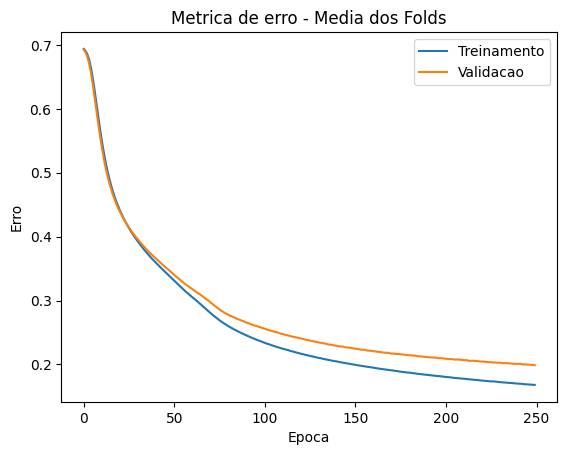

--> Acuracia media (treino): 0.9547
--> Acuracia media (validacao): 0.9444
--> acc_in - acc_val = 0.0103
--> loss medio do treino = 0.2616
--> loss medio da validacao = 0.2810
--> val_loss - train_loss = 0.0194



In [14]:
# Parâmetros: num_splits, numero_neuronios,dimensao_imput, list_funcoes_ativacao, X_train, Y_train, RANDOM_STATE, BATCH_SIZE, es = False, regularizador = False
k_fold(5, 2, X_train.shape[1], ['selu', 'sigmoid'], X_train, Y_train, RANDOM_STATE, BATCH_SIZE, es = True, regularizador = True)

# Criando a rede neural com os hiperparâmetros escolhidos

- Número de neurônios na camada escondida = 2
- Função de ativação da camada escondida = selu
- Função de ativação da camada de saída = sigmoid
- Otimizador = adam (learning rate padrão, 0.001)
- Early Stopping com 15 épocas de paciência
- 250 épocas de treinamento

In [15]:
# Criando a rede neural
model = Sequential()
# Adicionando as camadas e os neurônios em cada camada
model.add(Dense(2, input_dim=29, kernel_initializer='normal',kernel_regularizer=regularizers.l2(0.01) ,activation='selu')) #quantidade de neuronios na camada escondida, nº de features
model.add(Dense(1, kernel_initializer='normal', activation='sigmoid')) #camada de saída

# Taxa de aprendizado do otimizador
learning_rate = 0.001

# Criando um otimizador Adam com a taxa de aprendizado
otimizador = optimizers.Adam(learning_rate=learning_rate)

# Adicionando uma condição de parada Early Stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)

# Compilando o modelo
model.compile(loss = 'binary_crossentropy', optimizer = otimizador, metrics = ['accuracy'])



c:\Users\Bergson\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [16]:
# Treinando o modelo
history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=250, batch_size=BATCH_SIZE, verbose=0, callbacks=[es])

Epoch 242: early stopping


--> Acuracia (treino): 0.9475
--> Acuracia (validacao): 0.9430
--> Ein - Eval = 0.0045
--> val_loss - train_loss = 0.0738



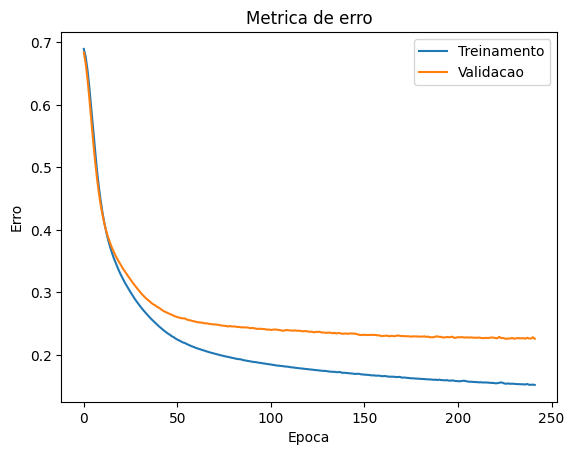

In [17]:
# Calculando a acuracia
_, accuracy_train = model.evaluate(X_train, Y_train, batch_size=BATCH_SIZE, verbose=0)
_, accuracy_val = model.evaluate(X_val, Y_val, batch_size=BATCH_SIZE, verbose=0)

# Plotando os resultados
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Metrica de erro')
plt.ylabel('Erro')
plt.xlabel('Epoca')
plt.legend(['Treinamento', 'Validacao'])


print(f'--> Acuracia (treino): {accuracy_train:.4f}')
print(f'--> Acuracia (validacao): {accuracy_val:.4f}')
print(f"--> Ein - Eval = {accuracy_train - accuracy_val:.4f}") 
print(f"--> val_loss - train_loss = {(history.history['val_loss'][-1] - history.history['loss'][-1]):.4f}\n")


In [18]:
# Avaliando o modelo com o classification report
Y_pred_train = np.round(model.predict(X_train))
print('Classification Report (treino):')
print(classification_report(Y_train, Y_pred_train))


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Classification Report (treino):
              precision    recall  f1-score   support

           0       0.92      0.98      0.95       312
           1       0.98      0.91      0.95       317

    accuracy                           0.95       629
   macro avg       0.95      0.95      0.95       629
weighted avg       0.95      0.95      0.95       629



In [19]:
Y_pred_val = np.round(model.predict(X_val))
print('Classification Report (validacao):')
print(classification_report(Y_val, Y_pred_val))

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Classification Report (validacao):
              precision    recall  f1-score   support

           0       0.92      0.97      0.94        78
           1       0.97      0.91      0.94        80

    accuracy                           0.94       158
   macro avg       0.94      0.94      0.94       158
weighted avg       0.94      0.94      0.94       158



# Utilizando os dados de teste

In [20]:
Y_pred_test = np.round(model.predict(X_test))
print('Classification Report (teste):')
print(classification_report(Y_test, Y_pred_test))

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Classification Report (teste):
              precision    recall  f1-score   support

           0       0.93      0.93      0.93       102
           1       0.93      0.93      0.93        95

    accuracy                           0.93       197
   macro avg       0.93      0.93      0.93       197
weighted avg       0.93      0.93      0.93       197

